# BastionAI example

## Finetuning DistilBERT for binary classification on the SMS Spam Collection

We will see in this notebook how BastionAI can be used to fine-tune a pre-trained DistilBERT model on a small dataset.
This can be useful, for instance, when one wants to leverage large pre-trained models on a smaller private dataset, for instance, medical or financial records, and ensure data privacy regarding users' data.

BastionAI is intended for scenarios where we have a data owner, for instance, a hospital, wanting to have third parties train models on their data, e.g. a startup, potentially on untrusted infrastructures, such as in the Cloud.

The strength of BastionaI is that the data owner can have a high level of protection on data shared to a remote enclave hosted in the Cloud, and operated by the startup, thanks to memory isolation and encryption, and remote attestation from the use of secure enclaves. 

In this notebook, we will illustrate how BlindAI works. We will use the publicly available dataset [SMS Spam Collection](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset) to finetune a DistilBERT model on a classification task, to predict whether an email is spam or not.

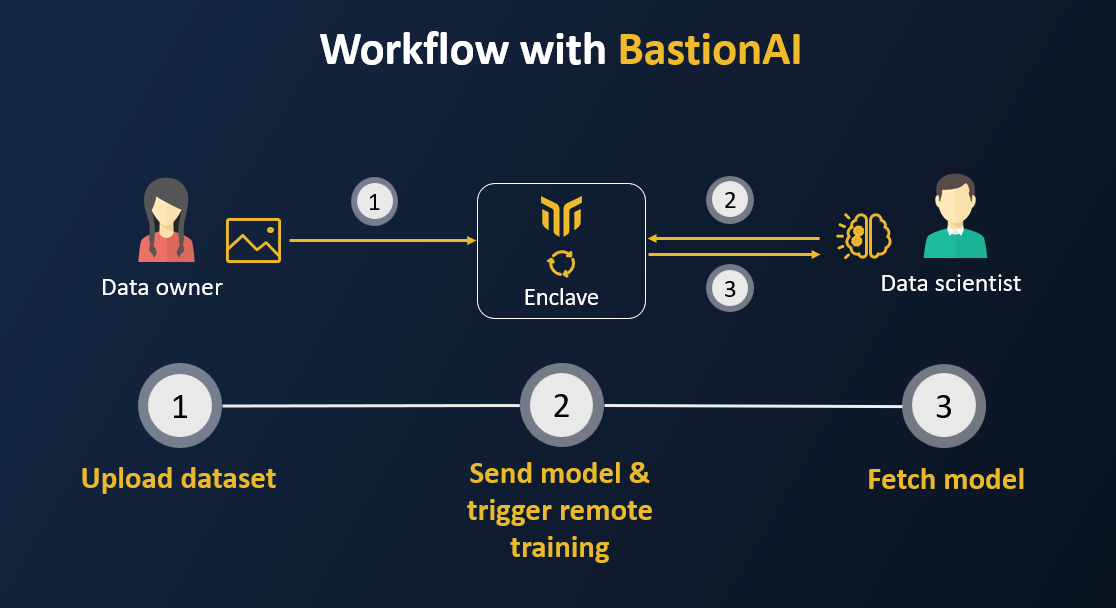

The workflow is simple:
- First, initialize the secure enclave used for training by launching our BastionAI server Docker image. 
- In an offline phase, the data owner prepares the dataset and the data scientist prepares the model.
- In an online phase, the dataset is uploaded to the secure enclave, the data scientist uploads his model inside the enclave, and have it be trained on the previously uploaded dataset, before pulling the weights once training is over.

Data preparation and training are largely based on https://towardsdatascience.com/fine-tuning-bert-for-text-classification-54e7df642894.


## Installing dependencies

### BastionAI

You can install BastionAI using our PyPI package:

In [ ]:
!pip install bastionai

### Installing other packages

Let's import all the necessary packages for this example

In [ ]:
!pip install transformers pandas ipykernel ipywidgets

We can now import necessary packages and objects:

### Installing Docker

Before proceeding, we need to start a local Bastion AI server. The simplest way is to use our official [Docker image](https://hub.docker.com/r/mithrilsecuritysas/bastionai).
You may also install from source as described in our [Getting Started](https://bastionai.readthedocs.io/en/latest/getting-started/quick-start/) page.
To proceed with the Docker, you need a working version of [Docker](https://docker-docs.netlify.app/install/).

## I - Launch BastionAI server

We first start by launching the BastionAI server using Docker. This instance will be in charge of doing the computation on the confidential data, and has to be run with the appropiate secure hardware. Here, for demonstration purposes, we will use a simulation image that can be run anywhere, but without the security guarantees.

In [ ]:
!docker run -p 50051:50051 -it mithrilsecuritysas/bastionai:latest

## II - Offline phase - Model and dataset preparation

### Data Owner POV: Preparing the Dataset

Here we will suppose we have a data owner who wants a third party data scientist to train an AI model to detect spam from emails.

The data owner will have to prepare the dataset first, and have it available in a PyTorch `DataSet` object before uploading it to the BastionAI server.

The dataset can be found at https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip. We will download and unzip it:

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
!unzip smsspamcollection.zip

Each row represent a sample, the label comes first followed by a tab and the raw text:
```
ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
ham	Ok lar... Joking wif u oni...
spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
```

We first load the data from the file into a pandas dataframe:

In [ ]:
import pandas as pd

file_path = "./SMSSpamCollection"

labels = []
texts = []
with open(file_path) as f:
    for line in f.readlines():
        split = line.split('\t')
        labels.append(1 if split[0] == "spam" else 0)
        texts.append(split[1])
df = pd.DataFrame({ "label": labels, "text": texts })
print(len(df))
df.head()

We then preprocess the data using a `DistilBertTokenizer` and we obtain tensors ready to be fed to the model:

In [ ]:
from transformers import DistilBertTokenizer
import torch

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

token_id = []
attention_masks = []
for sample in df.text.values:
    encoding_dict = tokenizer.encode_plus(
        sample,
        add_special_tokens=True,
        max_length=32,
        truncation=True,
        padding="max_length",
        return_attention_mask=True,
        return_tensors='pt'
    )
    token_id.append(encoding_dict['input_ids']) 
    attention_masks.append(encoding_dict['attention_mask'])

token_id = torch.cat(token_id, dim=0).to(dtype=torch.int64)
attention_masks = torch.cat(attention_masks, dim=0).to(dtype=torch.int64)
labels = torch.tensor(df.label.values, dtype=torch.int64)

Now, we will take only a subset of the dataset to make the training process faster. You can choose to take the whole dataset if you want.

In [ ]:
import numpy as np

test_ratio = 0.2
limit = 64
nb_samples = len(token_id)

idx = np.arange(nb_samples)
np.random.shuffle(idx)

train_idx = idx[int(test_ratio * nb_samples):][:limit]
test_idx = idx[:int(test_ratio * nb_samples)][:limit]

Next, we create two `TensorDataset` objects, that will be used to wrap our `Tensor` objects into a PyTorch `DataSet`

In [ ]:
from bastionai.utils import TensorDataset

train_set = TensorDataset([
    token_id[train_idx], 
    attention_masks[train_idx]
], labels[train_idx])

test_set = TensorDataset([
    token_id[test_idx], 
    attention_masks[test_idx]
], labels[test_idx])

### Data Scientist POV: Preparing the model

We now turn to preparing the DistilBERT language model. As Hugging Face's models typically have several outputs (logits, loss, etc.), we use Bastion AI's utility wrapper for models with multiple outputs to select only the output that corresponds with the logits. In fact, Bastion AI's server supports models with an arbitrtary number of inputs but only supports models with a single output.

In [ ]:
import torch.nn as nn

class MultipleOutputWrapper(nn.Module):
    """Utility wrapper to select one output of a model with multiple outputs.
    
    Args:
        module: A model with more than one output.
        output: Index of the output to retain.
    """
    def __init__(self, module: nn.Module, output: int = 0) -> None:
        super().__init__()
        self.inner = module
        self.output = output

    def forward(self, *args, **kwargs) -> torch.Tensor:
        output = self.inner.forward(*args, **kwargs)
        return output[self.output]

In [ ]:
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
    torchscript=True
)
model = MultipleOutputWrapper(model, 0) # This can be loaded from bastionai.utils

## Online phase - dataset and model upload and training

Now that the dataset and model are prepared, we can go to the online phase where the dataset is uploaded securely in the enclave, and the model is sent there for training.

### Data Owner POV: Uploading the Dataset

We will connect to the BastionAI instance using our library. Once connected, we use the `RemoteDataset` method to upload the datasets inside, provide a name, and set a Differential Privacy budget. Here we put an arbitrary number, but as a rule of thumb, the DP budget should be much lower, such as 4 or 8. 

In [ ]:
import bastionai

# The Data Owner privately uploads their model online
with bastionai.Connection("localhost", 50051) as client:
    remote_dataset = client.RemoteDataset(
        train_set, test_set,
        name="SMSSpamCollection",
        privacy_limit=1_000_000.0
    )

### Data Scientist POV: Uploading the model and trigger training

On the Data Scientist side, we use the `list_remote_datasets` endpoint to get a list of available datasets on the server that we can use for training.

In [ ]:
with bastionai.Connection("localhost", 50051) as client:
    remote_datasets = client.list_remote_datasets()

[str(ds) for ds in remote_datasets]

Here we see the dataset uploaded previously is available as a `RemoteDataset ` object.

In [ ]:
remote_datasets[0]

This object is a pointer to the remote dataset uploaded previously. Note that this is a **pointer that contains only metadata and nothing else**. This way, the data scientist can play with remote datasets without users' data being exposed.

We then use the `RemoteLearner` method to send the model to the server and to set all the necessary training parameters.

To start training, we just call the `fit` method on the `RemoteLearner` object with an appropriate number of epochs and DP budget. 
Note that behind the scenes, a DP-SGD training loop will be used.

We may finally retrieve a local copy of the trained model once the training is complete with the `get_model` method and test the model directly on the server with the `test` method.

In [ ]:
from bastionai.optimizer_config import Adam

# The Data Scientist discovers available datasets and uses one of them to train their model
with bastionai.Connection("localhost", 50051) as client:
    remote_learner = client.RemoteLearner(
        model,
        remote_datasets[0],
        max_batch_size=2,
        loss="cross_entropy",
        optimizer=Adam(lr=5e-5),
        model_name="DistilBERT",
    )

    remote_learner.fit(nb_epochs=2, eps=6.0)
    remote_learner.test(metric="accuracy")
    
    trained_model = remote_learner.get_model()